In [7]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.opengl)

#this sort is not a stable sort, beware
def BitonicSort():
    input = tf.input([-1, 2], tf.int32) #key, value
    N = input.shape[0]

    output = tf.copy(input)

    log2N = tf.ceil(tf.log2(tf.float(N)))
    Nround = tf.int(tf.exp2(log2N))
    steps = tf.int(log2N*(log2N + 1.0)/2.0)

    sort_id = tf.indices([Nround/2])[0]
    def sortingIteration(step):
        def getBitonicElementPair(id, step):
            j = tf.floor(tf.sqrt(tf.float(2*step) + 1.0) - 0.5)
            n = tf.round(tf.float(step) - 0.5*j*(j+1.0))
            B = tf.int(tf.round(tf.exp2(j-n)))
            mask = tf.select(n < 0.5, 2*B - 1, B)
            e1 = id%B + 2*B*(id/B)
            e2 = e1 ^ mask
            return e1, e2

        e1, e2 = getBitonicElementPair(sort_id, step)

        def sort():
            key1, key2 = output[e1, 0], output[e2, 0]
            val1, val2 = output[e1, 1], output[e2, 1]

            def swap():
                output[e1, 0] = key2
                output[e2, 0] = key1
                output[e1, 1] = val2
                output[e2, 1] = val1

            tf.if_cond(key1 > key2, swap)

        tf.if_cond((e1 < N) & (e2 < N), sort)

    tf.loop(sortingIteration, 0, steps, 1)

    return output

sort_program = tf.compile(BitonicSort)

BitonicSort:
  Kernel count: 2
  Intermediate buffers: 0
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 489
  IR Compile time: 3.941500 ms
  Steps time: 1512.216431 ms



In [8]:
all_kernels = tf.get_all_generated_kernels()
print("Generated kernels:")
for k in all_kernels:
    print(k[0][2])

Generated kernels:
layout (local_size_x = 2, local_size_y = 16, local_size_z = 1) in;

void main() {
  int block_id = int(gl_WorkGroupID.x);
  int block_thread_id0 = int(gl_LocalInvocationID.x);
  int block_thread_id1 = int(gl_LocalInvocationID.y);
  int block_thread_id2 = int(gl_LocalInvocationID.z);

  int blocks_shape_0 = ((2 + 2) - 1) / 2;
  int vdiv = block_id / blocks_shape_0;
  int index_0 = ((block_id - (vdiv * blocks_shape_0)) * 2) + block_thread_id0;
  int index_1 = (vdiv * 16) + block_thread_id1;
  bool is_inside_dispatch = (index_0 < 2) && (index_1 < var.N);
  if (is_inside_dispatch)
  {
    int input0 = asint(input0_mem[(index_1 * 2) + index_0]);
    int output0 = input0;
    output0_mem[(index_1 * 2) + index_0] = asuint(output0);
  }
}

layout (local_size_x = 256, local_size_y = 1, local_size_z = 1) in;

void main() {
  int block_id = int(gl_WorkGroupID.x);
  int block_thread_id0 = int(gl_LocalInvocationID.x);
  int block_thread_id1 = int(gl_LocalInvocationID.y);
  int bl

Error: 0


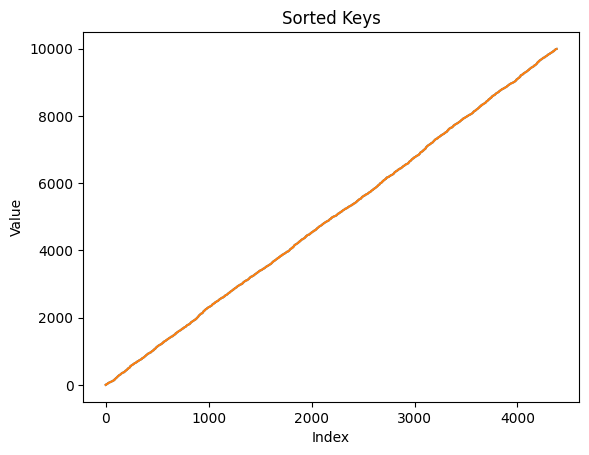

In [2]:
# Generate some random values
N = 4381
np.random.seed(0)
keys = np.random.randint(0, 10000, N)
values = np.arange(N)

# Sort the keys
data = np.column_stack((keys, values))
data_tf = tf.tensor(data)
sorted_data = sort_program(data_tf)
sorted_data = sorted_data.numpy

# Sort the keys using numpy
data = data[data[:, 0].argsort()]

# Compare the results
error = np.sum(np.abs(sorted_data[:, 0] - data[:, 0]))
print('Error:', error)

# Plot the sorted keys
plt.plot(sorted_data[:, 0])
plt.plot(data[:, 0])
plt.title('Sorted Keys')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()